<a href="https://colab.research.google.com/github/NsikakMenim/Machine-Learning-Portfolio./blob/main/analysis_of_insurance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal: To find out how Smoking, Age, and Regional Differences affect insurance charges.


## Research Questions
  * What drives insurance charges?
  * Identify which factors (age, BMI, smoking status, etc.) have the strongest influence on charges. How much do these factors contribute, and are there interactions (e.g., does BMI affect charges differently for smokers versus non-smokers)?
  * Create a model predict the charge for a new customer.

In [271]:
# Import Libraries
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [270]:
insurance_url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
urlretrieve(insurance_url, 'insurance.csv')

df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [99]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


##Exploratory Data Analysis
**Age**
#### Since Age is between 18 and 60, we need just 47 bins to visualize with a histogram

In [100]:
fig = px.histogram(df, x='age', marginal="box", nbins=47, title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()


The distribution of age is almost uniform, all the age groups have between 22 and 29 customers ach except for ages 18 and 19 that have 68 and 69 customers respectively.

**BMI**


In [101]:
fig = px.histogram(df, x='bmi', marginal="box", color_discrete_sequence=["red"], title='Distribution of BMI(Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()


This is a normal distribution with a peak around 30.


**Sex**

In [102]:
fig = px.histogram(df, x='sex', color='sex', title='Distribution of Sex')
fig.update_layout(bargap=0.1)
fig.show()

There are more male (676) customers than female (662) customers but the difference is not significant.

**Children**

In [103]:
fig = px.histogram(df, x='children', opacity= 0.8, title='Distribution of Children')
fig.update_layout(bargap=0.1)
fig.show()

Majority of respondents (584) have 0 children and only 18 have up to 5 children.

**Price**

In [104]:
fig = px.histogram(df, x='charges', marginal='box', color='smoker', color_discrete_sequence=['green', 'grey'], title='Distribution of Charges based on smoker status')
fig.update_layout(bargap=0.1)
fig.show()

Only non-smokers pay less than 12k. A second group of non-smokers pay between 12k and 32k and there are 5 non-smokers who pay between 32k and 36k. We will need further investigation to know why some non-smokers pay higher than others.

For smokers, the ones that pay between 12k and 32k and the others that pay between 32k and 50k. There are about 6 outliers that pay between 50k and 64k

In [105]:
fig = px.histogram(df, x='charges', marginal='box', color='sex', title='Distribution of Charges based on Sex')
fig.update_layout(bargap=0.1)
fig.show()

In [106]:
fig = px.histogram(df, x='charges', marginal='box', color='region', color_discrete_sequence=['grey', 'green', 'black', 'brown'], title='Distribution of Charges based on Region')
fig.update_layout(bargap=0.1)
fig.show()

In [107]:
fig = px.histogram(df, x='smoker', color='sex', title='Distribution of Smokers')
fig.update_layout(bargap=0.1)
fig.show()

In [108]:
fig = px.scatter(df, x='age', y='charges', color='smoker', opacity= 0.8, hover_data=['sex'], title='Relationship between Age and Charges')
fig.update_traces(marker=dict(size=5))
fig.show()


Observations:

1. The price increases with age.
2. There are 3 clusters of points, each forming a line;
*  Non smokers pay the lowest charge. Likely the ones with no underlying sickness.
*  There is a second group of non-smokers that pay higher and seem to be outliers from the group paying 5k and 16k. This group pay between 7k and 36k.
*  The smokers also pay within the range of the outlier smokers with a price range between 12k and 30k
*  The last line can be drawn for smokers who are charged higher than the other group of smokers and who might have underlying illness also


In [109]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker', opacity= 0.8, hover_data=['sex'], title='Relationship between BMI and Charges')
fig.update_traces(marker=dict(size=5))
fig.show()

Create some more grpahs to visualize how the charges column is related to the children, sex, region and smokers column.
Summarize insights gathered from this graph. Use violin plots and bar plots.

In [118]:
print('The correlation between charges and age is ' + str(round(df.charges.corr(df.age), 3)))
print('The correlation between charges and bmi is ' + str(round(df.charges.corr(df.bmi), 3)))
print('The correlation between charges and children is ' + str(round(df.charges.corr(df.children), 3)))

The correlation between charges and age is 0.299
The correlation between charges and bmi is 0.198
The correlation between charges and children is 0.068


In [121]:
smoker_binary = df['smoker'].map({'yes': 1, 'no': 0})
df['smoker_binary'] = smoker_binary

sex_binary = df['sex'].map({'male': 1, 'female': 0})
df['sex_binary'] = sex_binary

In [122]:
print('The correlation between charges and smoker_binary is ' + str(round(df.charges.corr(df.smoker_binary), 3)))
print('The correlation between charges and sex_binary is ' + str(round(df.charges.corr(df.sex_binary), 3)))

The correlation between charges and smoker_binary is 0.787
The correlation between charges and sex_binary is 0.057


In [123]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
one_hot = encoder.fit_transform(df[['region']])
one_hot

df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [125]:
print('The correlation between charges and northeast is ' + str(round(df.charges.corr(df.northeast), 3)))
print('The correlation between charges and northwest is ' + str(round(df.charges.corr(df.northwest), 3)))
print('The correlation between charges and southeast is ' + str(round(df.charges.corr(df.southeast), 3)))
print('The correlation between charges and southwest is ' + str(round(df.charges.corr(df.southwest), 3)))

The correlation between charges and northeast is 0.006
The correlation between charges and northwest is -0.04
The correlation between charges and southeast is 0.074
The correlation between charges and southwest is -0.043


In [126]:
df

,age,sex,bmi,children,smoker,region,charges,smoker_binary,sex_binary,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


In [128]:
corr_df = df[['charges','smoker_binary','age', 'bmi', 'children', 'sex_binary', 'northeast', 'northwest', 'southeast', 'southwest']]

In [129]:
corr_df.corr()

,charges,smoker_binary,age,bmi,children,sex_binary,northeast,northwest,southeast,southwest
charges,1.000000,0.787251,0.299008,0.198341,0.067998,0.057292,0.006349,-0.039905,0.073982,-0.043210
smoker_binary,0.787251,1.000000,-0.025019,0.003750,0.007673,0.076185,0.002811,-0.036945,0.068498,-0.036945
age,0.299008,-0.025019,1.000000,0.109272,0.042469,-0.020856,0.002475,-0.000407,-0.011642,0.010016
bmi,0.198341,0.003750,0.109272,1.000000,0.012759,0.046371,-0.138156,-0.135996,0.270025,-0.006205
children,0.067998,0.007673,0.042469,0.012759,1.000000,0.017163,-0.022808,0.024806,-0.023066,0.021914
sex_binary,0.057292,0.076185,-0.020856,0.046371,0.017163,1.000000,-0.002425,-0.011156,0.017117,-0.004184
northeast,0.006349,0.002811,0.002475,-0.138156,-0.022808,-0.002425,1.000000,-0.320177,-0.345561,-0.320177
northwest,-0.039905,-0.036945,-0.000407,-0.135996,0.024806,-0.011156,-0.320177,1.000000,-0.346265,-0.320829
southeast,0.073982,0.068498,-0.011642,0.270025,-0.023066,0.017117,-0.345561,-0.346265,1.000000,-0.346265
southwest,-0.043210,-0.036945,0.010016,-0.006205,0.021914,-0.004184,-0.320177,-0.320829,-0.346265,1.000000


<Axes: >

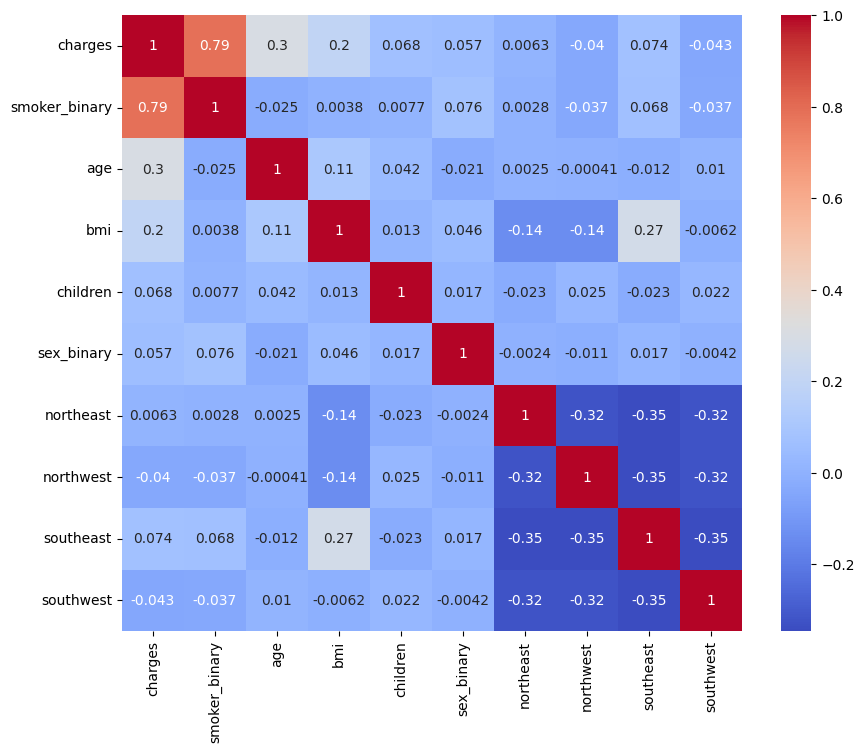

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')

## Applying Linear Regression Model

Applying Linear Regression to estimate the loss (rmse) and determine the features that contribute most to the charges.

We will begin with the more correlated features and check how adding other features affect the model

In [306]:
# Define features and target
X = df.drop('charges', axis=1)
y = df['charges']

In [307]:
# Preprocessor
categorical = ['sex', 'smoker', 'region']
numerical = ['age', 'bmi', 'children']

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical),
    ("num", StandardScaler(), numerical)
])


In [321]:
# Pipeline: preprocessor + feature selection + regression
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=5)),  # keep top 6 features
    ("reg", LinearRegression())
])

In [322]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [323]:
# Fit the pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('select',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x7bb92bcaa660>)),
                ('reg', LinearRegression())])

In [324]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 5815.516154139078
R²: 0.7821545605295674


In [325]:
# baseline
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 12465.610441715768


In [326]:
# Intercept and Coefficient
model = pipeline.named_steps['reg']
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

Intercept: 8545.96794534235
Coefficients: [23666.96075581  -249.47367451  3611.81511213  2006.17292632
   516.7966926 ]


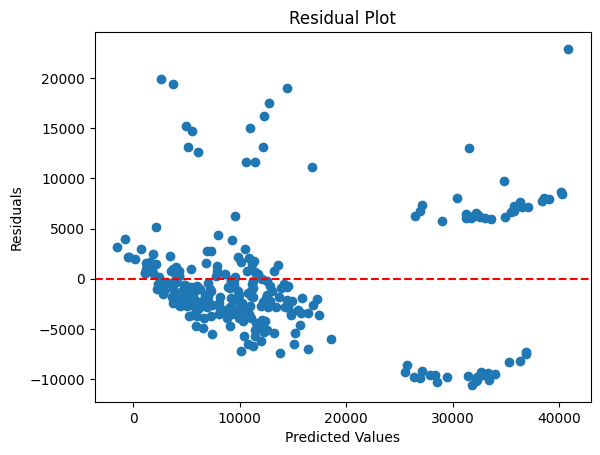

In [327]:
# 9. Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()


Selected features: ['smoker_yes', 'region_southeast', 'age', 'bmi', 'children']


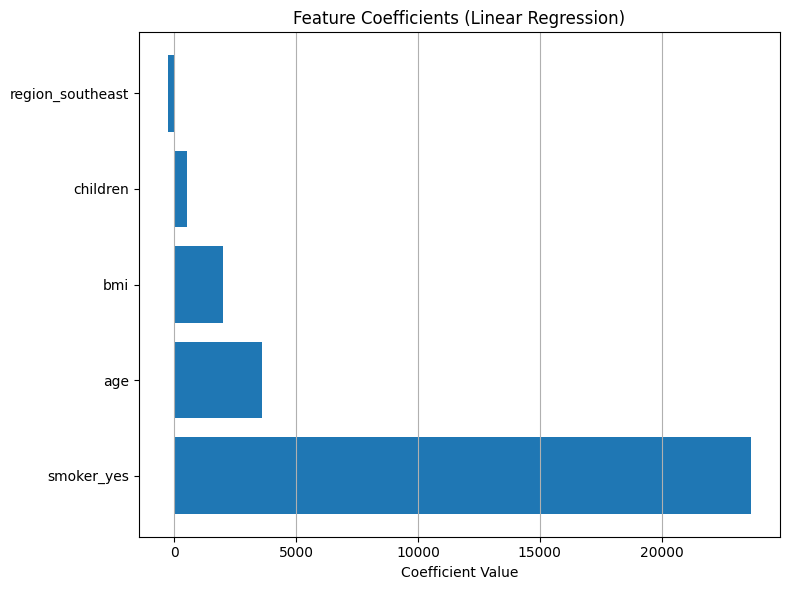

In [328]:
# Plotting Feature co-efficients

feature_names_cat = pipeline.named_steps['preproc'].named_transformers_['cat'] \
    .get_feature_names_out(categorical)

feature_names_num = numerical
all_feature_names = list(feature_names_cat) + feature_names_num

# Get mask of selected features
mask = pipeline.named_steps['select'].get_support()
selected_features = [name for i, name in enumerate(all_feature_names) if mask[i]]

print("Selected features:", selected_features)

# Get coefficients
coefs = pipeline.named_steps['reg'].coef_

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


Intercept: 8.810060039282963
Coefficients: [ 1.54185144 -0.05574492  0.4833589   0.06895148  0.1123954 ]
RMSE: 0.427865296054868
Baseline RMSE: 0.9510521355896449
R²: 0.7963959156024057


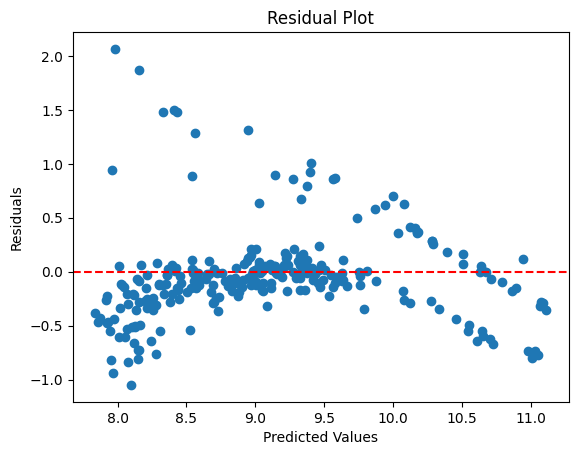

Selected features: ['smoker_yes', 'region_southwest', 'age', 'bmi', 'children']


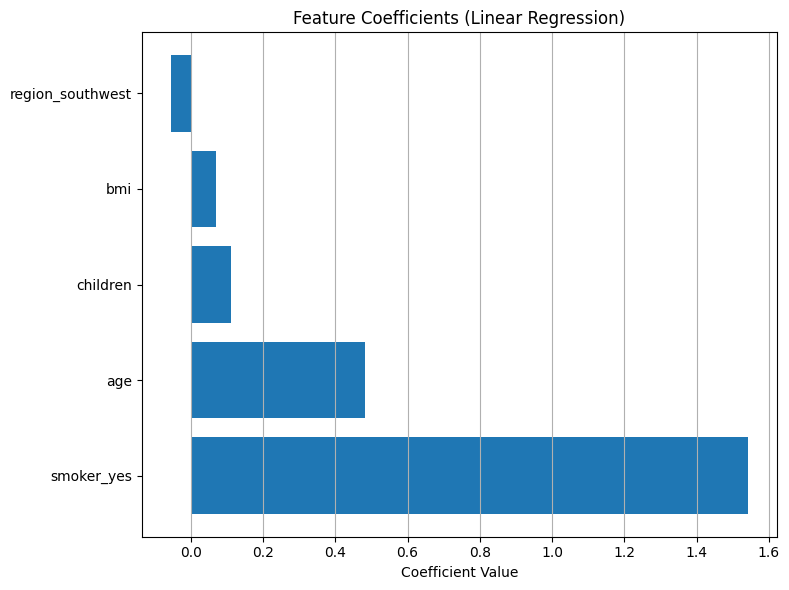

In [330]:
# Using a log transformation to compare results
X = df.drop('charges', axis=1)
y = np.log(df['charges'])

# 1. Define column types
categorical = ['sex', 'smoker', 'region']
numerical = ['age', 'bmi', 'children']

# 2. Preprocessor: encode categorical, scale numerical
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical),
    ("num", StandardScaler(), numerical)
])

# 3. Pipeline: preprocessor + feature selection + regression
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=5)),  # keep top 6 features
    ("reg", LinearRegression())
])

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit the pipeline
pipeline.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 7. Compare to baseline
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# 8. Access model
model = pipeline.named_steps['reg']
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(f"RMSE: {rmse}")
print(f"Baseline RMSE: {baseline_rmse}")
print(f"R²: {r2}")

# 9. Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 1. Get feature names after one-hot encoding + scaling
feature_names_cat = pipeline.named_steps['preproc'].named_transformers_['cat'] \
    .get_feature_names_out(categorical)

feature_names_num = numerical
all_feature_names = list(feature_names_cat) + feature_names_num

# 2. Get mask of selected features
mask = pipeline.named_steps['select'].get_support()
selected_features = [name for i, name in enumerate(all_feature_names) if mask[i]]

print("Selected features:", selected_features)

# Get coefficients
coefs = pipeline.named_steps['reg'].coef_

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


Intercept: 9.09596778704642
Coefficients: [ 0.15960927 -0.06266921  0.48623761  0.00922272  0.1136937   0.57281751]
RMSE: 0.41423885749500977
Baseline RMSE: 0.9510521355896449
R²: 0.8091579682746802


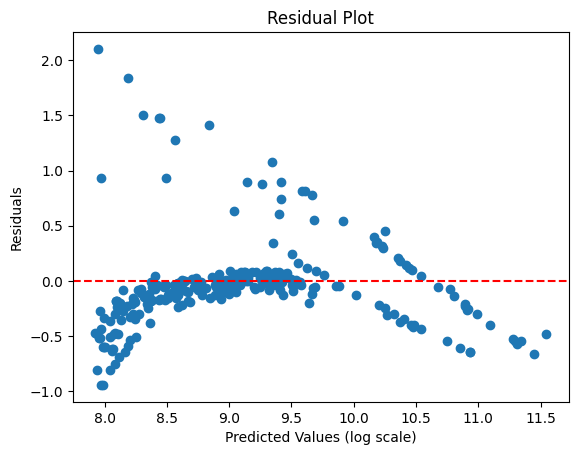

Selected features: ['smoker_yes', 'region_southwest', 'age', 'bmi', 'children', 'smoker_bmi']


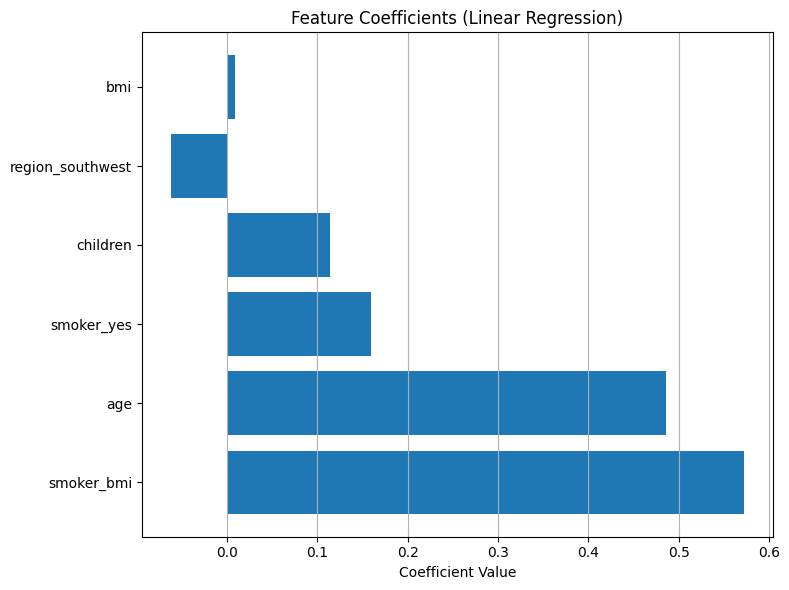

In [331]:
# Adding interaction term: smoker * bmi

df['smoker_bmi'] = df['bmi'] * (df['smoker'] == 'yes').astype(int)

# Define features and target
X = df.drop('charges', axis=1)
y = np.log(df['charges'])  # log-transform target to stabilize variance

# 1. Define column types
categorical = ['sex', 'smoker', 'region']
numerical = ['age', 'bmi', 'children', 'smoker_bmi']

# 2. Preprocessor: encode categorical, scale numerical
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical),
    ("num", StandardScaler(), numerical)
])

# 3. Pipeline: preprocessor + feature selection + regression
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=6)),  # top 6 features
    ("reg", LinearRegression())
])

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit the pipeline
pipeline.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 7. Baseline model: predict mean
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# 8. Access trained model
model = pipeline.named_steps['reg']
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(f"RMSE: {rmse}")
print(f"Baseline RMSE: {baseline_rmse}")
print(f"R²: {r2}")

# 9. Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values (log scale)")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 10. Get feature names after one-hot encoding + scaling
feature_names_cat = pipeline.named_steps['preproc'].named_transformers_['cat'] \
    .get_feature_names_out(categorical)

feature_names_num = numerical
all_feature_names = list(feature_names_cat) + feature_names_num

# 11. Get mask of selected features
mask = pipeline.named_steps['select'].get_support()
selected_features = [name for i, name in enumerate(all_feature_names) if mask[i]]

print("Selected features:", selected_features)

# Get coefficients
coefs = pipeline.named_steps['reg'].coef_

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# 12. Plot
plt.figure(figsize=(8,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
